# Using Elasticsearch for reading and query data from json format

# Table of Contents

0. Setup Elastic Stack Services
1. Install Dependencies
2. Connect to Elasticsearch
3. Data Import
4. Create a Pandas DataFrame
5. Elasticsearch Settings and Mappings
6. Format Data for Elasticsearch
7. Create Elasticsearch Index
8. Import Data into Elasticsearch
9. Query Elasticsearch
10. More Complicated Query
11. Kibana Visualization..WIP

### 0. Start Elastic Stack Services

In [ ]:
# Elastic Search service
!cd elasticsearch-8.10.4
!cd bin
elasticsearch

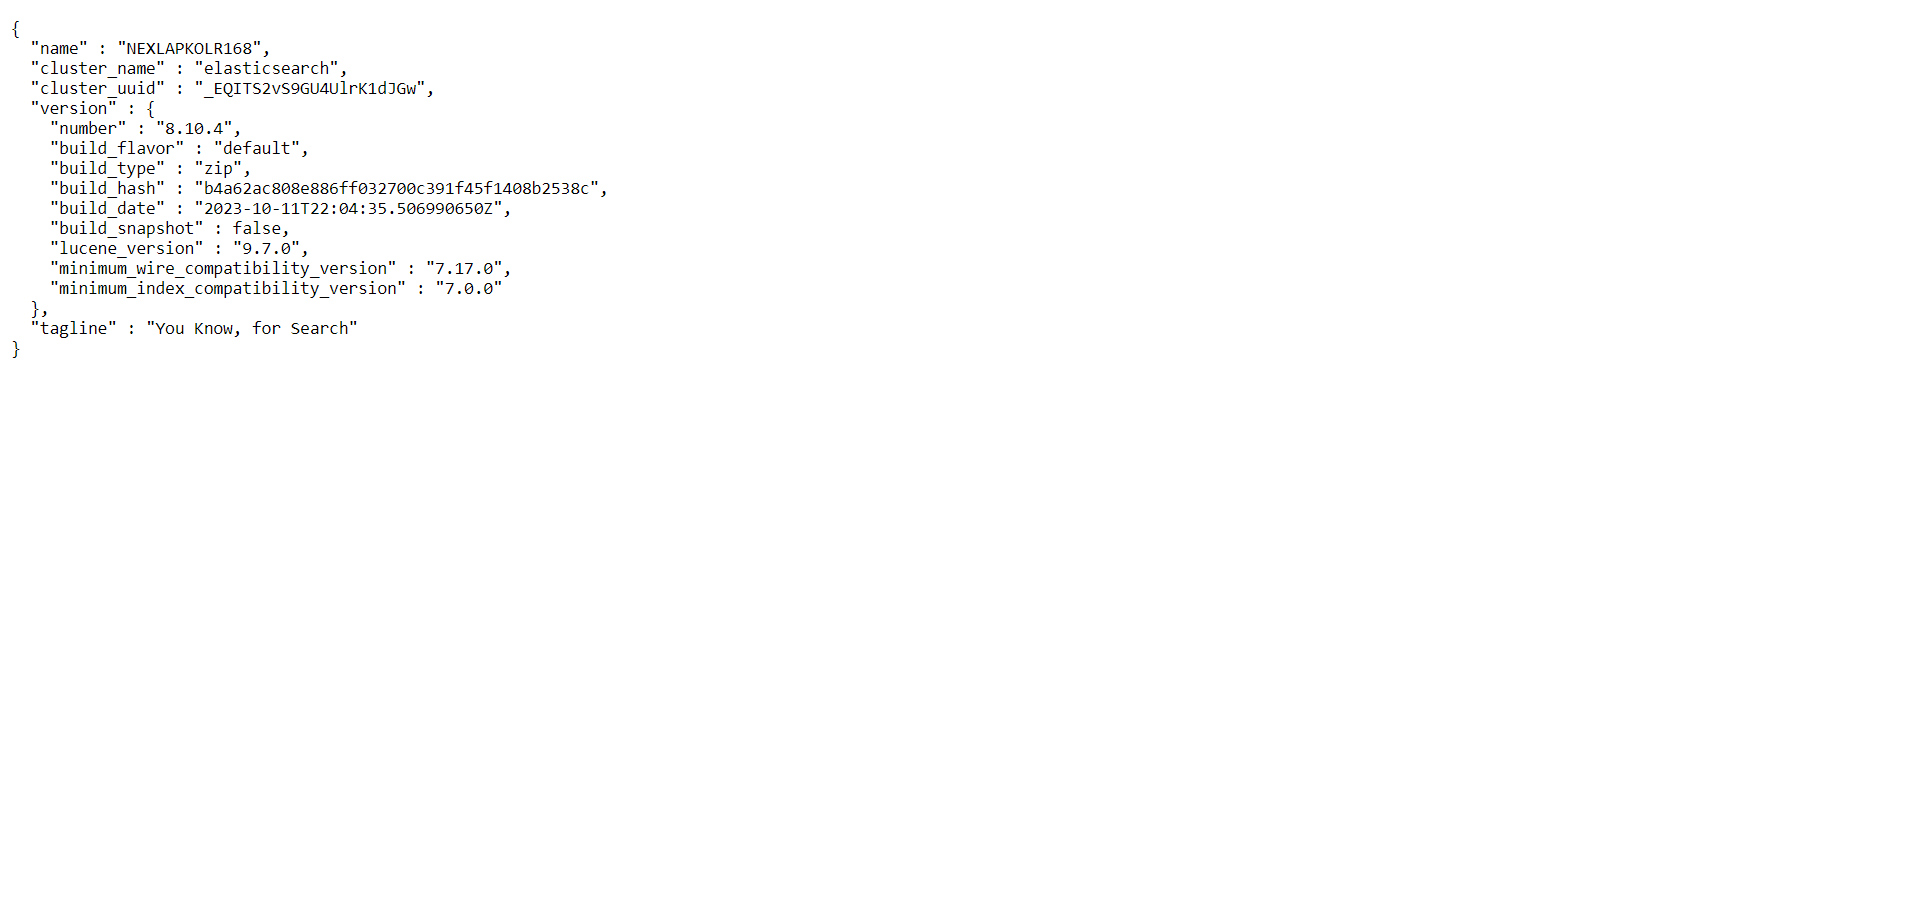

In [ ]:
# Kibana service
!cd kibana-8.10.4
!cd bin
kibana.bat

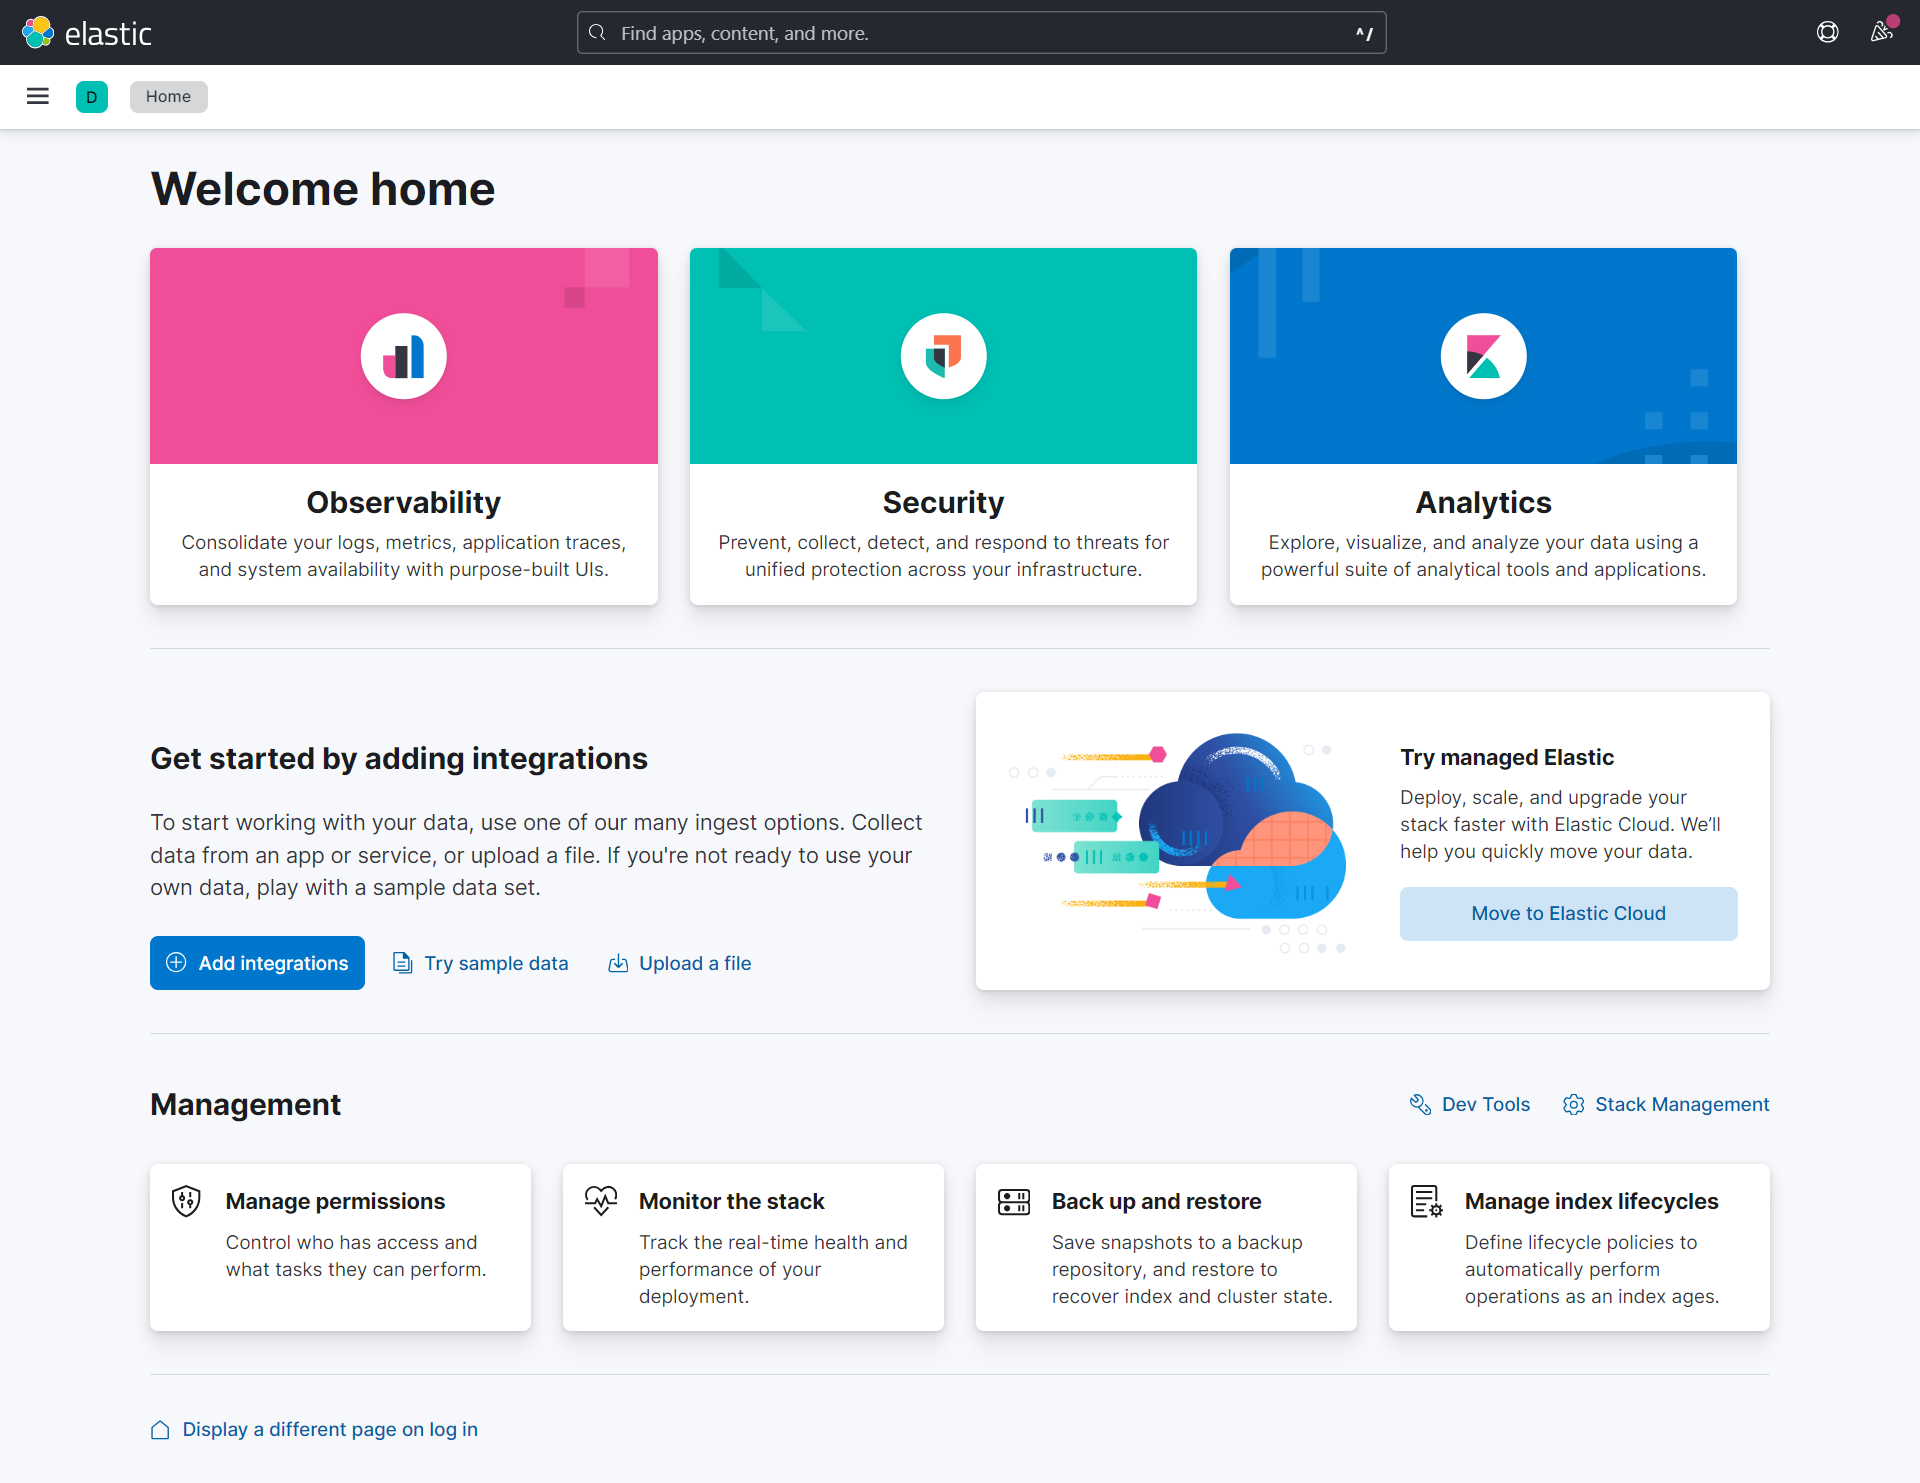

### 1. Install Dependencies

In [ ]:
!pip install elasticsearch

In [1]:
import elasticsearch
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import json
import pandas as pd

### 2. Connect to Elasticsearch

In [2]:
es = Elasticsearch(hosts = [{"host":"localhost", "port":9200, "scheme":"http"}])

# Check if python is connected to elasticsearch
es.ping()

True

### 3. Data Import

In [31]:
# Read data from the JSON file
data = []
with open('labelled_crime_reports.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

### 4. Create a Pandas DataFrame

In [32]:
# Convert to DataFrame
df = pd.DataFrame(data)
df.head()

,id,text,meta,annotation_approver,labels
0,2311,Officers were dispatched to a robbery of the A...,{},None,"[[30, 38, Crime], [45, 92, Address], [233, 248..."
1,2312,The MPD was called to Pink at West Towne Mall ...,{},None,"[[22, 45, Address], [46, 59, Crime_datetime], ..."
2,2313,"The MPD is seeking help locating a unique $1,5...",{},None,"[[66, 72, Crime], [91, 105, Address], [114, 13..."
3,2314,A Radcliffe Drive resident said three men - at...,{},None,"[[2, 17, Address], [79, 87, Weapon], [112, 130..."
4,2315,An 86-year-old woman contacted the MPD after p...,{},None,"[[460, 473, Crime], [821, 837, Reporting_offic..."


In [33]:
df = pd.DataFrame(columns=['text'])

In [34]:
# Iterate through the data and extract labeled information
for item in data:
    labels = item['labels']
    text = item['text']
    
    # Create a dictionary to store extracted labels and values
    extracted_info = {'text': text}
    
    for label in labels:
        start, end, column_name = label
        extracted_info[column_name] = text[start:end]
    
    # Append the extracted information to the DataFrame
    df = df.append(extracted_info, ignore_index=True)

In [36]:
print(f"shape of dataset: {df.shape}")
df.head()

shape of dataset: (189, 8)


,text,Address,Crime,Reported_date,Reported_time,Reporting_officer,Weapon,Crime_datetime
0,Officers were dispatched to a robbery of the A...,Associated Bank in the 1500 block of W Broadway,a demanded mone,d 08/09/20,t 6:17,y Sgt. Jennifer Ka,. No weap,NaN
1,The MPD was called to Pink at West Towne Mall ...,Pink at West Towne Mall,thefts,08/18/2016,10:37,PIO Joel Despain,NaN,Tuesday night
2,"The MPD is seeking help locating a unique $1,5...",Union St. home,stolen,08/17/2016,11:09 AM,PIO Joel Despain,NaN,that night
3,A Radcliffe Drive resident said three men - at...,Radcliffe Drive,targeted armed robbery,08/07/2018,11:17 AM,PIO Joel Despain,handguns,early this morning
4,An 86-year-old woman contacted the MPD after p...,NaN,fraud attempt,03/27/2019,10:28 AM,PIO Joel Despain,NaN,NaN


### 5. Elasticsearch Settings and Mappings

In [37]:
# Define settings & mappings of Elasticsearch index
Settings = {
    "settings":{
        "number_of_shards":1,
        "number_of_replicas":0
    },
    "mappings":{
        "properties":{
            "title":{
                "type":"text"
            },
            "abstract":{
                "type":"text"
            }
        }
    }
}

### 6. Format Data for Elasticsearch

In [38]:
def json_formatter(dataset, index_name, index_type='_doc'):
    """
    This function is used to create JSON formatted dictionaries for Elasticsearch.

    Args:
      dataset: The dataset you want to apply this function.
      index_name: Name of the index in elasticsearch
      index_type: Type of the index in elasticsearch.
      Note: It is suggested to keep index_type as '_doc', since it is deprecated from version 6.
      Note: This function formats all columns of your dataset, if you want to apply this to special columns only,
      you can delete the second for loop and add your custom fields.
    """
    try:
        List = []
        columns = dataset.columns
        for idx, row in dataset.iterrows():
            dic = {}
            dic['_index'] = index_name
            #dic['_type'] = index_type
            source = {}
            for i in dataset.columns:
                source[i] = row[i]
            dic['_source'] = source
            List.append(dic)
        return List
    
    except Exception as e:
        print("There is a problem: {}".format(e))

### 7. Create Elasticsearch Index

In [39]:
MY_INDEX = es.indices.create(index="crime_index", ignore=[400,404], body=Settings)
MY_INDEX

C:\Users\aviparna.biswas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  """Entry point for launching an IPython kernel.


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'crime_index'})

In [40]:
json_Formatted_dataset = json_formatter(dataset=df, index_name='crime_index')
json_Formatted_dataset[0]

{'_index': 'crime_index',
 '_source': {'text': 'Officers were dispatched to a robbery of the Associated Bank in the 1500 block of W Broadway. A M/W described as 5\'04" â€“ 5\'05" and 130 lbs., wearing a gray hooded sweatshirt, dark sunglasses, and a blue bandana around his mouth area demanded money from a teller. No weapon was mentioned or displayed. A K-9 track was attempted. The track ended at a nearby apartment complex. Released 08/09/2018 at 6:17 PM by Sgt. Jennifer Kane',
  'Address': 'Associated Bank in the 1500 block of W Broadway',
  'Crime': 'a demanded mone',
  'Reported_date': 'd 08/09/20',
  'Reported_time': 't 6:17 ',
  'Reporting_officer': 'y Sgt. Jennifer Ka',
  'Weapon': '. No weap',
  'Crime_datetime': nan}}

### 8. Import Data into Elasticsearch

In [41]:
#For importing Data to elasticsearch we use elasticsearch's bulk API from elasticsearch.helpers
try:
    res = helpers.bulk(es, json_Formatted_dataset)
    print("successfully imported to elasticsearch.")
except Exception as e:
    print(f"error: {e}")

error: 157 document(s) failed to index.


### 9. Query Elasticsearch

In [43]:
# Get 10 sample of data
query = es.search(
    index="crime_index",
    body={
      "size":10,
      "query": {
        "match_all":{}
      }
    }
)

output = pd.json_normalize((query['hits']['hits']))
output

,_index,_id,_score,_ignored,_source.text,_source.Address,_source.Crime,_source.Reported_date,_source.Reported_time,_source.Reporting_officer,_source.Weapon,_source.Crime_datetime
0,crime_index,ei41pIsBMl_S57pQyM8g,1.0,[text.keyword],A Radcliffe Drive resident said three men - at...,Radcliffe Drive,targeted armed robbery,08/07/2018,11:17 AM,PIO Joel Despain,handguns,early this morning
1,crime_index,fS41pIsBMl_S57pQyM8g,1.0,[text.keyword],A convenience store clerk was robbed at gunpoi...,south on Todd Dr.,robbed at gunpoint,12/14/2017,9:28 AM,PIO Joel Despain,weapon,before 11:00 p.m
2,crime_index,gS41pIsBMl_S57pQyM8g,1.0,[text.keyword],"""It's the scariest thing in my whole life,"" an...","State St., near the Capitol Square",stabbing,09/11/2017,8:58 AM,PIO Joel Despain,knife,early this morning
3,crime_index,gi41pIsBMl_S57pQyM8g,1.0,[text.keyword],A group of children are believed responsible f...,"Falk Elementary School, 6323 Woodington Way",shattered glass,06/19/2017,12:24 PM,PIO Joel Despain,brick,Saturday afternoon
4,crime_index,gy41pIsBMl_S57pQyM8g,1.0,[text.keyword],Madison Police Responded to the 3000 Block of ...,3000 Block of Darbo Drive,stab,11/25/2016,2:25 PM,Sgt. Nicholas Ellis,broken glass,12:30PM
5,crime_index,iC41pIsBMl_S57pQyM8g,1.0,[text.keyword],"A 13-year-old boy, who pointed a handgun at a ...",1500 block of Troy,disorderly conduct while armed,10/12/2016,10:11 AM,PIO Joel Despain,BB or pellet gun,last night
6,crime_index,ii41pIsBMl_S57pQyM8g,1.0,[text.keyword],A Madison mother was driving with her 18-year-...,East Washington Ave.,road rage incident,06/11/2019,9:10 AM,PIO Joel Despain,handgun,Monday morning
7,crime_index,my41pIsBMl_S57pQyM8g,1.0,[text.keyword],A concerned caller told police a driver fired ...,"Center for Limnology, 680 N. Park St.",weapon's violation,07/06/2018,10:55 AM,PIO Joel Despain,flare gun,3:00 a.m.
8,crime_index,ny41pIsBMl_S57pQyM8g,1.0,[text.keyword],A crime victim and his neighbor - who came out...,McKee Rd.,theft,06/30/2016,1:01 PM,PIO Joel Despain,handgun,4:20 a.m.
9,crime_index,oi41pIsBMl_S57pQyM8g,1.0,[text.keyword],"On June 11, 2019 at approximately 11:09pm, Mad...",E. Gilman and E. Gorham Street,pistol whipped,06/12/2019,1:15 AM,Sgt. Nathan Becker,firearm,"June 11, 2019 at approximately 11:09pm"


### 10. More Complicated Query

In [46]:
# More complicated query
query = es.search( 
    index="crime_index",
    body={
        "size":20,
        "query":{
            "bool":{
                "must":[
                        {"multi_match":{
                            "query":"Cases which officer despain handled",
                            "fields":["text","address","crime","reported_time"]
                        }}
                ]
            }
        }
    }
)

output = pd.json_normalize((query['hits']['hits']))
output

,_index,_id,_score,_ignored,_source.text,_source.Address,_source.Crime,_source.Reported_date,_source.Reported_time,_source.Reporting_officer,_source.Weapon,_source.Crime_datetime
0,crime_index,my41pIsBMl_S57pQyM8g,2.809790,[text.keyword],A concerned caller told police a driver fired ...,"Center for Limnology, 680 N. Park St.",weapon's violation,07/06/2018,10:55 AM,PIO Joel Despain,flare gun,3:00 a.m.
1,crime_index,KC41pIsBMl_S57pQyNAg,2.809790,[text.keyword],A concerned caller told police a driver fired ...,"the Center for Limnology, 680 N. Park",ht's weapon's viol,Released,06/2018,0:55 AM by PIO J,h a flare,"e Fourth of July, around 11:00 p."
2,crime_index,ny41pIsBMl_S57pQyM8g,2.426172,[text.keyword],A crime victim and his neighbor - who came out...,McKee Rd.,theft,06/30/2016,1:01 PM,PIO Joel Despain,handgun,4:20 a.m.
3,crime_index,ei41pIsBMl_S57pQyM8g,2.146952,[text.keyword],A Radcliffe Drive resident said three men - at...,Radcliffe Drive,targeted armed robbery,08/07/2018,11:17 AM,PIO Joel Despain,handguns,early this morning
4,crime_index,iC41pIsBMl_S57pQyM8g,1.937227,[text.keyword],"A 13-year-old boy, who pointed a handgun at a ...",1500 block of Troy,disorderly conduct while armed,10/12/2016,10:11 AM,PIO Joel Despain,BB or pellet gun,last night
5,crime_index,DS41pIsBMl_S57pQyNAg,1.937227,[text.keyword],"A 13-year-old boy, who pointed a handgun at a ...",1500 block of Troy,disorderly conduct while armed,10/12/2016,10:11 AM,PIO Joel Despain,BB or pellet gun,last night
6,crime_index,wi41pIsBMl_S57pQyM8g,1.935944,[text.keyword],"A knife-wielding man, who threatened a couple ...",downtown,screaming at others,11/12/2018,10:02 AM,PIO Joel Despain,knife,Sunday afternoon
7,crime_index,xi41pIsBMl_S57pQyM8g,1.791400,[text.keyword],A Madison woman was arrested last night after ...,S. Bedford St.,"smashing the cars headlights, taillights, rear...",05/18/2016,12:13 PM,PIO Joel Despain,tire iron,night after
8,crime_index,ii41pIsBMl_S57pQyM8g,1.787826,[text.keyword],A Madison mother was driving with her 18-year-...,East Washington Ave.,road rage incident,06/11/2019,9:10 AM,PIO Joel Despain,handgun,Monday morning
9,crime_index,gS41pIsBMl_S57pQyM8g,1.701061,[text.keyword],"""It's the scariest thing in my whole life,"" an...","State St., near the Capitol Square",stabbing,09/11/2017,8:58 AM,PIO Joel Despain,knife,early this morning
